In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
!tar xf spark-3.0.3-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark==3.0.3

     |████████████████████████████████| 209.1 MB 63 kB/s 
     |████████████████████████████████| 198 kB 57.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435970 sha256=8986884817907a550f2e2c8ad4f1309baedd7573685b999bdb1117480e312c85
  Stored in directory: /root/.cache/pip/wheels/7e/6d/0a/6b0bf301bc056d9af03194b732b9f49ad2fceb205aab2984fd
Successfully built pyspark


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [3]:
! wget https://files.grouplens.org/datasets/movielens/ml-latest.zip

--2021-12-17 22:18:14--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  70.4MB/s    in 4.0s    

2021-12-17 22:18:18 (66.0 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]



In [4]:
!unzip 'ml-latest.zip'

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


In [5]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession

In [6]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf,col,when,desc

import numpy as np
from IPython.display import Image
from IPython.display import display

In [7]:
conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [8]:
ratings=spark.read.load('/content/ml-latest/ratings.csv', format='csv', inferSchema=True, header=True)
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [9]:
movies=spark.read.load('/content/ml-latest/movies.csv', format='csv', inferSchema=True, header=True)
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [10]:
tags=spark.read.load('/content/ml-latest/tags.csv', format='csv', inferSchema=True, header=True)
tags.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [11]:
links=spark.read.load('/content/ml-latest/links.csv', format='csv', inferSchema=True, header=True)
links.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [12]:
training_set,testing_set=ratings.randomSplit([0.8,0.2])
training_set.count()

22200250

In [13]:
als=ALS(maxIter=10,regParam=0.1,rank=4,userCol="userId",itemCol="movieId",ratingCol="rating")
model=als.fit(training_set)
predictions=model.transform(testing_set)
new_predictions=predictions.filter(col('prediction')!=np.nan)
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
rmse=evaluator.evaluate(new_predictions)
print("root mean square error"+ str(rmse))

root mean square error0.8303111700954836


In [14]:
predictions.show(10)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|106148|    148|   2.5|1207008368| 2.8924303|
|234926|    148|   4.0| 836315177| 2.9414966|
| 50155|    148|   3.0| 956789580| 2.9227197|
|207939|    148|   3.0| 970170090| 2.7589483|
| 60382|    148|   4.0| 830077276| 3.5675318|
| 51571|    148|   3.0| 976588402| 3.0586288|
|211963|    148|   3.0| 903702432| 2.2720916|
|224445|    148|   3.0| 866125989| 2.8216264|
|149383|    148|   3.0| 837033792|  2.715311|
| 73492|    148|   0.5|1234676991|  2.432334|
+------+-------+------+----------+----------+
only showing top 10 rows



In [15]:
predictions.join(movies,"movieId").select("userId","title","genres","prediction").show(5)

+------+--------------------+------+----------+
|userId|               title|genres|prediction|
+------+--------------------+------+----------+
|106148|Awfully Big Adven...| Drama| 2.8924303|
|234926|Awfully Big Adven...| Drama| 2.9414966|
| 50155|Awfully Big Adven...| Drama| 2.9227197|
|207939|Awfully Big Adven...| Drama| 2.7589483|
| 60382|Awfully Big Adven...| Drama| 3.5675318|
+------+--------------------+------+----------+
only showing top 5 rows



In [16]:
##Recommending movies for each particular user
particular_user=predictions.filter(col("userId")==599).join(movies,"movieID").join(links,"movieId").select("userId","title","genres","tmdbId","prediction")
particular_user=particular_user.sort(desc("prediction"))
particular_user.show(10)

+------+--------------------+--------------------+------+----------+
|userId|               title|              genres|tmdbId|prediction|
+------+--------------------+--------------------+------+----------+
|   599|Reservoir Dogs (1...|Crime|Mystery|Thr...|   500|  3.721089|
|   599|Laputa: Castle in...|Action|Adventure|...| 10515|  3.639781|
|   599|Saving Private Ry...|    Action|Drama|War|   857|  3.623132|
|   599|Good Will Hunting...|       Drama|Romance|   489| 3.5453663|
|   599|Dark Knight, The ...|Action|Crime|Dram...|   155| 3.5018146|
|   599|           Up (2009)|Adventure|Animati...| 14160| 3.4659812|
|   599|Django Unchained ...|Action|Drama|Western| 68718|   3.37715|
|   599|Bourne Ultimatum,...|Action|Crime|Thri...|  2503|  3.229712|
|   599|Dark Crystal, The...|   Adventure|Fantasy| 11639| 3.1304994|
|   599|     Iron Man (2008)|Action|Adventure|...|  1726|  2.965444|
+------+--------------------+--------------------+------+----------+
only showing top 10 rows



In [17]:
##Generating top 5 recommendations for each user

user_recommendations=model.recommendForAllUsers(5)

#Generating top 5 user recommendations for each movie

movie_recommendations=model.recommendForAllItems(5)

In [18]:
user_recommendations.select("userId","recommendations.movieId").show(10,False)

+------+----------------------------------------+
|userId|movieId                                 |
+------+----------------------------------------+
|148   |[171579, 151989, 137040, 185211, 177007]|
|463   |[171579, 151989, 137040, 122222, 177007]|
|471   |[151989, 177209, 171579, 107434, 157791]|
|496   |[151989, 171579, 177209, 142891, 107434]|
|833   |[171579, 171851, 158306, 176363, 179063]|
|1088  |[171579, 151989, 177209, 179063, 158306]|
|1238  |[171579, 151989, 177007, 137040, 185211]|
|1342  |[185645, 146240, 193759, 185647, 176517]|
|1580  |[151989, 185659, 185645, 177209, 185647]|
|1591  |[171579, 177209, 151989, 176597, 159761]|
+------+----------------------------------------+
only showing top 10 rows



In [19]:
movie_recommendations.select("movieId","recommendations.userId").show(10,False)

+-------+---------------------------------------+
|movieId|userId                                 |
+-------+---------------------------------------+
|148    |[139119, 216815, 229364, 86766, 252626]|
|463    |[261317, 29446, 124751, 126803, 63517] |
|471    |[239966, 7507, 49889, 198702, 29446]   |
|496    |[139119, 229364, 86766, 216815, 148311]|
|833    |[261317, 268794, 192403, 140712, 10538]|
|1088   |[63210, 6743, 19387, 124751, 97354]    |
|1238   |[63210, 259178, 139119, 86766, 6743]   |
|1342   |[261317, 11053, 268794, 29446, 2573]   |
|1580   |[29446, 239966, 7507, 261317, 6743]    |
|1591   |[261317, 268794, 2573, 11053, 140712]  |
+-------+---------------------------------------+
only showing top 10 rows



In [20]:
#User recommendations for a group of user subset
users=ratings.select("userId").distinct().limit(5)
users.show()

+------+
|userId|
+------+
|   148|
|   463|
|   471|
|   496|
|   833|
+------+



In [21]:
user_subset_recommendations=model.recommendForUserSubset(users,10)

In [22]:
user_subset_recommendations.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[151989, 5.84636...|
|   463|[[171579, 4.27298...|
|   833|[[171579, 6.37006...|
|   496|[[151989, 6.88873...|
|   148|[[171579, 6.61254...|
+------+--------------------+



In [23]:
user_subset_recommendations.select("userId","recommendations.movieId").show(10,False)

+------+--------------------------------------------------------------------------------+
|userId|movieId                                                                         |
+------+--------------------------------------------------------------------------------+
|471   |[151989, 177209, 171579, 107434, 157789, 157791, 190707, 142891, 159761, 185659]|
|463   |[171579, 151989, 137040, 122222, 177007, 185211, 98693, 162436, 142891, 135735] |
|833   |[171579, 171851, 158306, 176363, 179063, 182021, 173775, 185659, 177209, 151989]|
|496   |[151989, 171579, 177209, 142891, 107434, 137040, 157791, 157789, 192089, 98693] |
|148   |[171579, 151989, 137040, 185211, 177007, 185659, 177209, 142891, 122222, 139074]|
+------+--------------------------------------------------------------------------------+



In [24]:
movies_subset=ratings.select("movieId").distinct().limit(3)
movie_subset_recommendations=model.recommendForItemSubset(movies_subset,10)
movie_subset_recommendations.select("movieId","recommendations.userId").show(10,False)

+-------+---------------------------------------------------------------------------+
|movieId|userId                                                                     |
+-------+---------------------------------------------------------------------------+
|471    |[7507, 239966, 49889, 198702, 29446, 11053, 215098, 72477, 264439, 59810]  |
|1591   |[261317, 268794, 2573, 11053, 140712, 29446, 10538, 142610, 126803, 167837]|
|1645   |[261317, 29446, 11053, 239966, 7507, 59810, 51588, 2573, 268794, 88274]    |
+-------+---------------------------------------------------------------------------+



In [25]:
###Illustrating some spark sql queries for visualization
#finding how many movies that each user voted
from pyspark.sql import functions as F

new_movie_dataset=ratings.join(movies,"movieId").select("userId","movieId","title","genres","rating")
new_movie_dataset1=new_movie_dataset.groupBy('userId').agg(F.count('movieId').alias('total_movie_votes'))
new_movie_dataset1.sort(desc('total_movie_votes')).show()

+------+-----------------+
|userId|total_movie_votes|
+------+-----------------+
|123100|            23715|
|117490|             9279|
|134596|             8381|
|212343|             7884|
|242683|             7515|
|111908|             6645|
| 77609|             6398|
| 63783|             6346|
|172357|             5868|
|141955|             5810|
|158002|             5701|
|253511|             5356|
| 48470|             5257|
|183233|             5169|
| 94843|             5130|
| 73145|             5042|
| 37046|             5041|
|187986|             4951|
|  4796|             4874|
|236981|             4854|
+------+-----------------+
only showing top 20 rows



Plotting users and their total number of ratings for movies

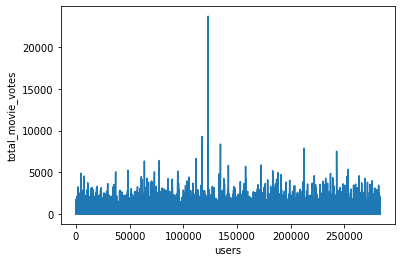

In [26]:
import matplotlib.pyplot as plt

plot_data=new_movie_dataset1.toPandas()
users=plot_data['userId']
total_movie_votes=plot_data['total_movie_votes']

plt.plot(users,total_movie_votes)
plt.xlabel("users")
plt.ylabel("total_movie_votes")
plt.show()

In [27]:
new_movie_dataset2=new_movie_dataset.groupBy('movieId').agg(F.count('userId').alias('total_user_votes'))
new_movie_dataset2.show()

+-------+----------------+
|movieId|total_user_votes|
+-------+----------------+
|   1591|            6508|
|   1645|           15215|
|    471|           12308|
|   1088|           14100|
|   1580|           44287|
|   3997|            2484|
|   3175|           16713|
|   6620|            4262|
|   2122|            2908|
|   2142|            2521|
|   2866|            1486|
|   3918|            1501|
|   4519|            2664|
|   7982|             928|
|   8638|            5134|
|  96488|            1330|
|  54190|            2551|
|    463|             432|
|    833|            1562|
|   1342|            4049|
+-------+----------------+
only showing top 20 rows



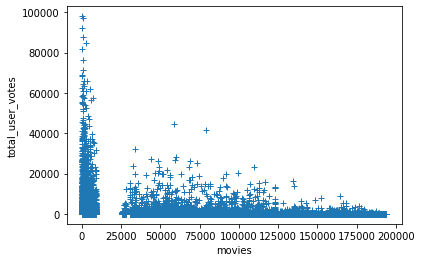

In [28]:
import matplotlib.pyplot as plt

plot_data1=new_movie_dataset2.toPandas()
movies=plot_data1['movieId']
total_user_vote=plot_data1['total_user_votes']

plt.plot(movies,total_user_vote,'+')
plt.xlabel("movies")
plt.ylabel("total_user_votes")
plt.show()